In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
def label_type(row):
    """
    TYPE:
        假日半尖峰 (六)8:00~22:00 -> 0
        假日離峰 (六)0:00~8:00、22:00~24:00 (日)0:00~24:00 -> 1
        平日尖峰 (夏季)10:00~12:00、13:00~17:00 -> 2
        平日半尖峰 (夏季)8:00~10:00、12:00~13:00、17:00~22:00 (非夏季)8:00~22:00 -> 3
        平日離峰 0:00~8:00、22:00~24:00 -> 4
    """
    row['month'] = int(row['時間'].strftime('%m'))
    row['day_of_week'] = int(row['時間'].weekday())
    row['hour'] = int(row['時間'].strftime('%H'))
    row['type'] = -1

    if row['day_of_week'] == 6:
        if (row['hour'] >= 8) and (row['hour'] < 22):
            row['type'] = 0
        else:
            row['type'] = 1

    elif row['day_of_week'] == 0:
        row['type'] = 1

    else:
        # summer 6~9
        if (row['month']>=6) and (row['month']<=9):
            if row['hour'] in [10, 11, 13, 14, 15, 16]:
                row['type'] = 2
            elif row['hour'] in [8, 9, 12, 17, 18, 19, 20, 21]:
                row['type'] = 3
            else:
                row['type'] = 4
        else:
            if (row['hour'] >= 8) and (row['hour'] < 22):
                row['type'] = 3
            else:
                row['type'] = 4

    return row

In [4]:
def plot(df1, df2):

    plt.figure(1, figsize=(20,10))
    plt.subplot(2, 1, 1)
    plt.title('Consumption')
    plt.xticks(np.arange(5), ['hol_medium', 'hol_low', 'unhol_high', 'unhol_medium', 'unhol_low'])
    for user in df1.columns:
        plt.plot(np.arange(df1.shape[0]), df1[user], label=str(user))
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title('Consumption Normal')
    plt.xticks(np.arange(5), ['hol_medium', 'hol_low', 'unhol_high', 'unhol_medium', 'unhol_low'])
    for user in df2.columns:
        plt.plot(np.arange(df2.shape[0]), df2[user], label=str(user))
    plt.legend()
    # plt.savefig('clustering_of_consumption.png')

In [5]:
def user_analysis(df_consumption, df_generation):
    df_col = df_consumption.columns[1:]

    df_consumption = df_consumption.apply(label_type, axis=1)

    df_consumption_normal = df_consumption.copy()
    df_consumption_normal[df_col] = pd.DataFrame(MinMaxScaler().fit_transform(df_consumption_normal[df_col]))

    df_consumption = df_consumption.groupby('type').agg({'用戶1': ['mean'], '用戶2': ['mean'], '用戶3': ['mean'], '用戶4': ['mean'],\
                                    '用戶5': ['mean'], '用戶6': ['mean'], '用戶7': ['mean'], '用戶8': ['mean']})
    df_consumption_normal = df_consumption_normal.groupby('type').agg({'用戶1': ['mean'], '用戶2': ['mean'], '用戶3': ['mean'], '用戶4': ['mean'],\
                                    '用戶5': ['mean'], '用戶6': ['mean'], '用戶7': ['mean'], '用戶8': ['mean']})

    # df_generation = df_generation.groupby('type').agg({'電廠01_發電量_01': ['mean'],'電廠02_發電量_01': ['mean'], '電廠03_發電量_01': ['mean'], '電廠04_發電量_01': ['mean'],\
    #                                 '電廠05_發電量_01': ['mean'], '電廠06_發電量_01': ['mean'], '電廠07_發電量_01': ['mean'], '電廠08_發電量_01': ['mean']})

    print(df_consumption)
    print(df_consumption_normal)

    plot(df_consumption, df_consumption_normal)

In [6]:
def graph(df1, df2):
    plt.figure(1, figsize=(20,10))
    plt.subplot(2, 1, 1)
    plt.title('Cluster Consumption')
    plt.xticks(np.arange(df1.shape[0]), df1.index)
    for user in df1.columns:
        plt.plot(np.arange(df1.shape[0]), df1[user], label=str(user))
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title('Generation')
    plt.xticks(np.arange(df2.shape[0]), df2.index)
    for user in df2.columns:
        plt.plot(np.arange(df2.shape[0]), df2[user], label=str(user))
    plt.legend()

In [35]:
def month_analysis(df_consumption, df_generation):
    df_col = df_consumption.columns[1:]

    cluster_1 = df_consumption[['用戶1', '用戶2', '用戶3', '用戶8']].sum(axis=1)
    print(cluster_1)
    cluster_2 = df_consumption[['用戶4']].sum(axis=1)
    cluster_3 = df_consumption[['用戶5', '用戶6', '用戶7']].sum(axis=1)

    df_clusters = pd.DataFrame({'時間':df_consumption['時間'], 'cluster_1':cluster_1, 'cluster_2':cluster_2, 'cluster_3':cluster_3})

    df_clusters = df_clusters.apply(label_type, axis=1)
    df_generation = df_generation.apply(label_type, axis=1)

    df_clusters = df_clusters.groupby(['month', 'type']).agg({'cluster_1': ['sum'],'cluster_2': ['sum'], 'cluster_3': ['sum']})
    # df_generation = df_generation.groupby(['month', 'type']).agg({'電廠1': ['sum'],'電廠2': ['sum'], '電廠3': ['sum'], '電廠4': ['sum'],\
    #                                 '電廠5': ['sum'], '電廠6': ['sum'], '電廠7': ['sum'], '電廠8': ['sum']})
    # df_generation = df_generation.groupby(['month', 'type']).agg({'電廠1': ['sum'],'電廠2': ['sum'], '電廠3': ['sum'], '電廠4': ['sum'],\
    #                                 '電廠5': ['sum'] })
    df_generation = df_generation.groupby(['month', 'type']).agg({'電廠1': ['sum'], '電廠4': ['sum']})
    df_clusters.to_csv('df_clusters.csv')
    df_generation.to_csv('df_generation.csv')

    graph(df_clusters, df_generation)

In [44]:
    DATASET_NUM = '1_case1' # if changing to other dataset, you need to adjust above column names and sizes.
    df_consumption = pd.read_csv('DataSet/dataset'+DATASET_NUM+'/power_consumption.csv', parse_dates=['時間'])
    df_generation = pd.read_csv('DataSet/dataset'+DATASET_NUM+'/power_generation.csv', parse_dates=['時間'])

             用戶1         用戶2         用戶3         用戶4         用戶5         用戶6  \
            mean        mean        mean        mean        mean        mean   
type                                                                           
0      42.054945   12.395055  117.914286  794.434341  894.043956  346.857143   
1      85.787330   45.420928  167.292308  787.616516  890.998303  344.252828   
2     166.678030  142.284091  313.997727  766.950000  907.156061  368.366667   
3     122.374152   70.247473  230.989891  800.465643  898.027383  343.496225   
4      49.258467   17.722912  107.253103  782.929885  893.044521  343.542069   

             用戶7         用戶8  
            mean        mean  
type                          
0     566.182692   46.257143  
1     562.581561   96.545928  
2     608.163636  224.906818  
3     563.168650  131.819898  
4     559.740307   58.356858  
           用戶1       用戶2       用戶3       用戶4       用戶5       用戶6       用戶7  \
          mean      mean      mea

C:\ProgramData\Anaconda3\envs\aibox\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\aibox\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\envs\aibox\lib\site-pack

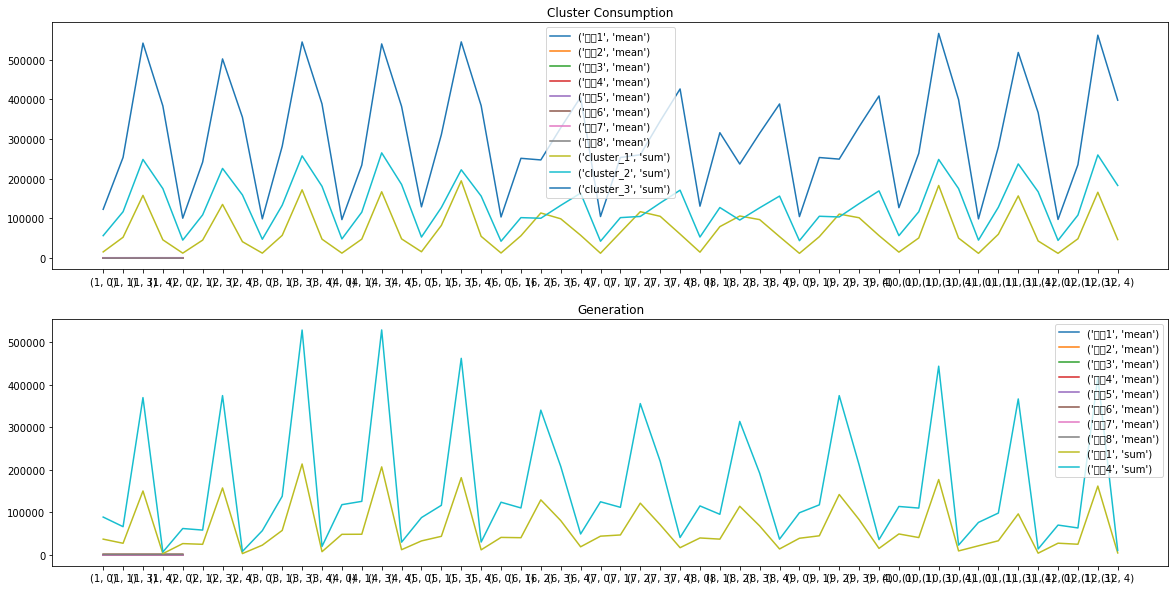

In [45]:
    # do clustering for consumptions
    user_analysis(df_consumption, df_generation)

    # show different time slots(months, types) of clusters of consumption and generations.
    month_analysis(df_consumption, df_generation)